In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [2]:
data = []
with open("multinli_1.0_train.jsonl", "r") as f:
    for line in f:
        data.append(json.loads(line))

In [3]:
len(data)

392702

In [4]:

for i  in range (10):
    print('data'+str(i))
    print('annotation:',data[i]['annotator_labels'])
    print('sentence1:',data[i]['sentence1'])
    print('sentence2:',data[i]['sentence2'])
    print('\n')

data0
annotation: ['neutral']
sentence1: Conceptually cream skimming has two basic dimensions - product and geography.
sentence2: Product and geography are what make cream skimming work. 


data1
annotation: ['entailment']
sentence1: you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him
sentence2: You lose the things to the following level if the people recall.


data2
annotation: ['entailment']
sentence1: One of our number will carry out your instructions minutely.
sentence2: A member of my team will execute your orders with immense precision.


data3
annotation: ['entailment']
sentence1: How do you know? All this is their information again.
sentence2: This information belongs to them.


data4
annotation: ['neutral']
sentence1: yeah i tell you what though if you 

In [5]:
extracted_data = [{'sentence1': item['sentence1'], 

                   'sentence2': item['sentence2'], 

                   'gold_label': item['gold_label']} 

                  for item in data if item['gold_label'] in ['neutral', 'entailment', 'contradiction']]

# Convertir en DataFrame pour simplifier le traitement

df = pd.DataFrame(extracted_data)

# Aperçu des données extraites

df.head()

,sentence1,sentence2,gold_label
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,neutral
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,entailment
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,entailment
3,How do you know? All this is their information...,This information belongs to them.,entailment
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,neutral


In [6]:
df_subset = df.sample(n=5000, random_state=42)

In [8]:
def common_word_ratios(s1, s2):
    words1 = set(str(s1).split())
    words2 = set(str(s2).split())
    common = len(words1 & words2)
    return common / max(len(words1), 1), common / max(len(words2), 1)

# Ajouter une colonne avec le nombre de mots en commun
df_subset["common_ratio_s1"], df_subset["common_ratio_s2"] = zip(*df_subset.apply(lambda row: common_word_ratios(row["sentence1"], row["sentence2"]), axis=1))


In [9]:
df_subset

,sentence1,sentence2,gold_label,common_ratio_s1,common_ratio_s2
155219,That's all right.,That's fine.,entailment,0.333333,0.500000
327538,Televisions are expensive these days.,Televisions cost $200 when you purchase them f...,neutral,0.200000,0.111111
325456,The colonial porte cochre sets the tone for Wa...,The colonial porte coche on the front of the p...,neutral,0.235294,0.307692
341461,and you just sift,"Don't sift, ever.",contradiction,0.000000,0.000000
54698,You think there's somethin' in all that talk T...,Topham had supported the talk due to his own d...,neutral,0.133333,0.166667
...,...,...,...,...,...
201204,You'd think instead of messing around with Win...,Old people mostly like brand names that they h...,neutral,0.052632,0.076923
108582,because i know on some at times the news you k...,I had based my opinion on what I had seen on t...,entailment,0.176471,0.375000
201821,pardon yes right there needs to be more than o...,There needs to be a measure of certainty befor...,neutral,0.419355,0.722222
267942,As the name chosen for the Clear Skies Act imp...,Implementation of the SO2 and NOx emissions ca...,entailment,0.258065,0.666667


In [10]:
label_mapping = {"neutral": 0, "contradiction": 1, "entailment": 2}
df_subset['gold_label'] = df_subset['gold_label'].map(label_mapping)

In [11]:
df_subset['gold_label'][1:10]

327538    0
325456    0
341461    1
54698     0
38374     1
284865    2
333146    2
216074    1
125620    0
Name: gold_label, dtype: int64

In [12]:
vectorizer = TfidfVectorizer(max_features=5000)  # Limite à 5000 features pour éviter la surcharge mémoire
X1 = vectorizer.fit_transform(df_subset["sentence1"])
X2 = vectorizer.transform(df_subset["sentence2"])

In [14]:
X_common_s1 = np.array(df_subset["common_ratio_s1"]).reshape(-1, 1)
X_common_s2 = np.array(df_subset["common_ratio_s2"]).reshape(-1, 1)

In [15]:
from scipy.sparse import hstack

In [16]:
X = hstack([X1, X2, X_common_s1, X_common_s2])
y = df_subset["gold_label"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
svm_model = SVC(kernel="linear")
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [19]:
y_pred = svm_model.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))

               precision    recall  f1-score   support

      neutral       0.48      0.48      0.48       344
contradiction       0.50      0.51      0.50       320
   entailment       0.50      0.49      0.50       336

     accuracy                           0.49      1000
    macro avg       0.49      0.49      0.49      1000
 weighted avg       0.49      0.49      0.49      1000



              precision    recall  f1-score   support

           0       0.48      0.48      0.48       344
           1       0.50      0.51      0.50       320
           2       0.50      0.49      0.50       336

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.49      0.49      0.49      1000



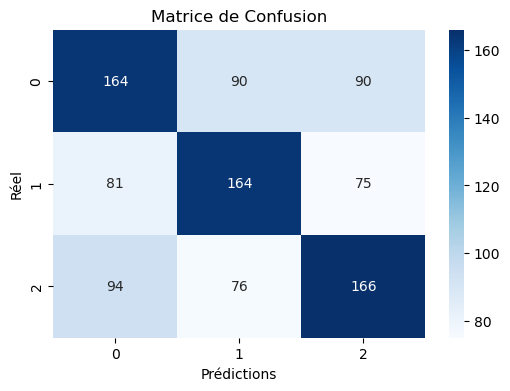

In [21]:
print(classification_report(y_test, y_pred))

# Générer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de Confusion")
plt.show()